# Lab 2

Preparing the data, computing basic statistics, and constructing simple models are essential steps for data science practice. In this lab, we will try the whole pipeline using PyTorch. Specifically, we will first get familar with the implementation of DNN in PyTorch. Then, we will perform mortality prediction based on the last visit's diagnosis codes using DNN.


Table of Contents:
- Nonlinearity
- DNN with Pytorch
- Assignment
    - Preprocessing
    - DNN Model
    
Some contents of this lab are adapted from [Dive into Deep Learning](https://d2l.ai) and [Official PyTorch Tutorials](https://pytorch.org/tutorials/).

In [1]:
import os
import csv
import random
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import Counter
import matplotlib.pyplot as plt

In [2]:
# set seed
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)

In [3]:
# make dir "deliverables"
DELIVERABLE_PATH = 'deliverables/'
if not os.path.isdir(DELIVERABLE_PATH):
    os.mkdir(DELIVERABLE_PATH)

In [4]:
DATA_PATH = "../LAB2-lib/data"
assert os.path.isdir(DATA_PATH)
!ls {DATA_PATH}

ADMISSIONS.csv	DIAGNOSES_ICD.csv  PATIENTS.csv


## 1. Nonlinearity

### 1.1 Linear Models May Go Wrong

Previously, we implement the linear regression model. However, linear model may sometimes go wrong. 

This is because linearity implies the weaker assumption of monotonicity: that any increase in our feature must either always cause an increase in our model’s output (if the corresponding weight is positive), or always cause a decrease in our model’s output (if the corresponding weight is negative). 

However, we can easily come up with examples that violate monotonicity. Say for example that we want to predict probability of death based on body temperature. For individuals with a body temperature above 37°C (98.6°F), higher temperatures indicate greater risk. However, for individuals with body temperatures below 37°C, higher temperatures indicate lower risk! In this case too, we might resolve the problem with some clever feature engineering. Namely, we might use the distance from 37°C as our feature.

But what if we want to predict mortality based on diagnosis. It is very hard to perform feature engineering, which requires a lot of domain knowledge.

### 1.2 Incorporating Hidden Layers

We can overcome these limitations of linear models and handle a more general class of functions by incorporating one or more hidden layers. The easiest way to do this is to stack many fully-connected layers on top of each other. Each layer feeds into the layer above it, until we generate outputs. We can think of the first $L−1$ layers as our representation and the final layer as our linear predictor. This architecture is commonly called a multilayer perceptron, often abbreviated as MLP. Below, we depict an MLP diagrammatically

<img src='./img/mlp.svg'>

Formally, this MLP can be expressed as:
$$
\begin{split}\begin{aligned}
    \mathbf{H} & = \mathbf{X} \mathbf{W}^{(1)} + \mathbf{b}^{(1)}, \\
    \mathbf{O} & = \mathbf{H}\mathbf{W}^{(2)} + \mathbf{b}^{(2)}.
\end{aligned}\end{split}
$$

### 1.3 From Linear to Nonlinear

You might be surprised to find out that—in the model defined above—we gain nothing for our troubles! The reason is plain. The hidden units above are given by an affine function of the inputs, and the outputs are just an affine function of the hidden units. An affine function of an affine function is itself an affine function. Moreover, our linear model was already capable of representing any affine function. That is:

$$
\mathbf{O} = (\mathbf{X} \mathbf{W}^{(1)} + \mathbf{b}^{(1)})\mathbf{W}^{(2)} + \mathbf{b}^{(2)} = \mathbf{X} \mathbf{W}^{(1)}\mathbf{W}^{(2)} + \mathbf{b}^{(1)} \mathbf{W}^{(2)} + \mathbf{b}^{(2)} = \mathbf{X} \mathbf{W} + \mathbf{b}.
$$

In order to realize the potential of multilayer architectures, we need one more key ingredient: a nonlinear activation function $\sigma$ to be applied to each hidden unit following the affine transformation. The outputs of activation functions (e.g.,  $\sigma(\cdot))$) are called activations. In general, with activation functions in place, it is no longer possible to collapse our MLP into a linear model:

$$
\begin{split}\begin{aligned}
    \mathbf{H} & = \sigma(\mathbf{X} \mathbf{W}^{(1)} + \mathbf{b}^{(1)}), \\
    \mathbf{O} & = \mathbf{H}\mathbf{W}^{(2)} + \mathbf{b}^{(2)}.\\
\end{aligned}\end{split}
$$

Activation functions decide whether a neuron should be activated or not by calculating the weighted sum and further adding bias with it. They are differentiable operators to transform input signals to outputs, while most of them add non-linearity. Because activation functions are fundamental to deep learning, let us briefly survey some common activation functions.

**ReLU Function**

The most popular choice, due to both simplicity of implementation and its good performance on a variety of predictive tasks, is the rectified linear unit (ReLU). ReLU provides a very simple nonlinear transformation. Given an element $x$, the function is defined as the maximum of that element and $0$:

$$\operatorname{ReLU}(x) = \max(x, 0).$$

Informally, the ReLU function retains only positive elements and discards all negative elements by setting the corresponding activations to 0. To gain some intuition, we can plot the function. As you can see, the activation function is piecewise linear.

Text(0, 0.5, 'relu(x)')

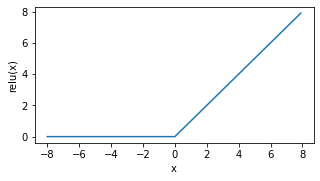

In [5]:
x = torch.arange(-8.0, 8.0, 0.1)
y = torch.relu(x)
plt.figure(figsize=(5, 2.5))
plt.plot(x.detach(), y.detach())
plt.xlabel('x')
plt.ylabel('relu(x)')

### Exercise 1 [10 points]

Plot the Tanh Function.

Hint: try `torch.tanh()`.

Text(0, 0.5, 'tanh(x)')

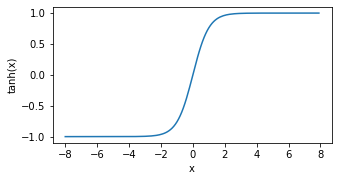

In [6]:
x = torch.arange(-8.0, 8.0, 0.1)
y = torch.tanh(x)

plt.figure(figsize=(5, 2.5))
plt.plot(x.detach(), y.detach())
plt.xlabel('x')
plt.ylabel('tanh(x)')

In [7]:
'''
AUTOGRADER CELL. DO NOT MODIFY THIS.
'''

x = torch.arange(-8.0, 8.0, 0.1)
assert torch.allclose(y, torch.tanh(x), rtol=1e-2)



## 2. DNN Model

From a programing standpoint, a DNN model is represented by a class. Any subclass of it must define a forward propagation function that transforms its input into output and must store any necessary parameters. Note that some subclasses do not require any parameters at all. Finally a model must possess a backpropagation function, for purposes of calculating gradients. Fortunately, due to some behind-the-scenes magic supplied by the auto differentiation when defining our own model, we only need to worry about parameters and the forward propagation function.

The following code generates a network with one fully-connected hidden layer with 256 units and ReLU activation, followed by a fully-connected output layer with 10 units (no activation function).

In [8]:
net = nn.Sequential(nn.Linear(20, 256), nn.ReLU(), nn.Linear(256, 10))

X = torch.rand(2, 20)

net(X)

tensor([[ 0.1677,  0.2065, -0.2746, -0.1013,  0.2246,  0.1783,  0.0501, -0.0086,
         -0.0600, -0.2115],
        [ 0.1484,  0.1665, -0.2590, -0.1304,  0.0505,  0.1214, -0.1044, -0.0971,
         -0.0822, -0.1282]], grad_fn=<AddmmBackward0>)

In this example, we constructed our model by instantiating an `nn.Sequential`, with layers in the order that they should be executed passed as arguments. In short, `nn.Sequential` defines a special kind of Module, the class that presents a model in PyTorch. It maintains an ordered list of constituent Modules. Note that each of the two fully-connected layers is an instance of the `Linear` class which is itself a subclass of Module. The forward propagation (forward) function is also remarkably simple: it chains each block in the list together, passing the output of each as the input to the next. Note that until now, we have been invoking our models via the construction `net(X)` to obtain their outputs. This is actually just shorthand for `net.__call__(X)`.

**A Custom Model**

Perhaps the easiest way to develop intuition about how a model works is to implement one ourselves. Before we implement our own custom model, we briefly summarize the basic functionality that each model must provide:

- Ingest input data as arguments to its forward propagation function.
- Generate an output by having the forward propagation function return a value. Note that the output may have a different shape from the input.
- Calculate the gradient of its output with respect to its input, which can be accessed via its backpropagation function. Typically this happens automatically.
- Store and provide access to those parameters necessary to execute the forward propagation computation.
- Initialize model parameters as needed.

In the following snippet, we code up a model from scratch corresponding to an MLP with one hidden layer with 256 hidden units, and a 10-dimensional output layer. Note that the MLP class below inherits the class that represents a model. We will heavily rely on the parent class’s functions, supplying only our own constructor (the `__init__` function in Python) and the forward propagation function.

In [9]:
class MLP(nn.Module):
    # Declare a layer with model parameters. Here, we declare two fully
    # connected layers
    def __init__(self):
        # Call the constructor of the `MLP` parent class `Module` to perform
        # the necessary initialization. In this way, other function arguments
        # can also be specified during class instantiation, such as the model
        # parameters, `params` (to be described later)
        super().__init__()
        self.hidden = nn.Linear(20, 256)  # Hidden layer
        self.out = nn.Linear(256, 10)  # Output layer

    # Define the forward propagation of the model, that is, how to return the
    # required model output based on the input `X`
    def forward(self, X):
        # Note here we use the funtional version of ReLU defined in the
        # nn.functional module.
        return self.out(F.relu(self.hidden(X)))

Let us first focus on the forward propagation function. Note that it takes X as the input, calculates the hidden representation with the activation function applied, and outputs its logits.

We instantiate the MLP’s layers in the constructor and subsequently invoke these layers on each call to the forward propagation function. Note a few key details. First, our customized `__init__` function invokes the parent class’s `__init__` function via `super().__init__()` sparing us the pain of restating boilerplate code applicable to most blocks. We then instantiate our two fully-connected layers, assigning them to `self.hidden` and `self.out`. Note that unless we implement a new operator, we need not worry about the backpropagation function or parameter initialization. The system will generate these functions automatically. Let us try this out.

In [10]:
net = MLP()
net(X)

tensor([[ 1.7738e-01,  1.2829e-01,  6.3749e-02,  4.8818e-02,  7.5020e-05,
          1.4179e-01, -4.1864e-02, -9.4340e-02,  6.6383e-02,  1.5124e-01],
        [ 8.7345e-02,  8.7090e-02,  1.6082e-01, -6.5498e-02,  4.6025e-02,
         -6.3113e-03,  4.5823e-02, -6.2649e-02,  3.2010e-02,  1.0640e-01]],
       grad_fn=<AddmmBackward0>)

### Exercise 2 [20 points]

Implement the following model architecture.

Layers | Configuration | Activation Function
--- | --- | ---
fully connected | input size 128, output size 64 | ReLU
fully connected | input size 64, output size 32 | ReLU
dropout | probability 0.5 | -
fully connected | input size 32, output size 1 | Sigmoid

In [11]:
"""
TODO: Build the MLP shown above.
HINT: Consider using `nn.Linear`, `nn.Dropout`, `F.relu`, `torch.sigmoid`.
"""

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # DO NOT change the names
        self.fc1 = nn.Linear(128, 64)   # Fully connected layer: input size 128, output size 64
        self.fc2 = nn.Linear(64, 32)    # Fully connected layer: input size 64, output size 32
        self.dropout = nn.Dropout(0.5)  # Dropout layer with probability 0.5
        self.fc3 = nn.Linear(32, 1)     # Fully connected layer: input size 32, output size 1

    def forward(self, x):
        x = F.relu(self.fc1(x))         # Apply ReLU activation after the first fully connected layer
        x = F.relu(self.fc2(x))         # Apply ReLU activation after the second fully connected layer
        x = self.dropout(x)             # Apply dropout
        x = torch.sigmoid(self.fc3(x))  # Apply Sigmoid activation after the final fully connected layer
        return x

In [12]:
'''
AUTOGRADER CELL. DO NOT MODIFY THIS.
'''

model = Net()

assert model.fc1.in_features == 128
assert model.fc1.out_features == 64
assert model.fc2.in_features == 64
assert model.fc2.out_features == 32
assert model.fc3.in_features == 32
assert model.fc3.out_features == 1

x = torch.rand(2, 128)
output = model.forward(x)
assert output.shape == (2, 1), "Net() is wrong!"



## Assignment [70 points]

In this assignment, you will use [MIMIC-III](https://physionet.org/content/mimiciii/1.4/) clinical data as raw input to perform Mortality Prediction.

### Preprocessing

MIMIC-III is a large, freely-available database comprising deidentified health-related data associated with over 40,000 patients who stayed in critical care units of the Beth Israel Deaconess Medical Center between 2001 and 2012.

Due to license issue, we will use the [MIMIC-III Demo](https://physionet.org/content/mimiciii-demo/) dataset, which contains all intensive care unit (ICU) stays for 100 patients.

The goal is to extract the diagnosis codes for each admission (model input) and the mortality information (model output).

#### Patient

This table defines each subject_id in the database, i.e. defines a single patient.

In [13]:
patients = pd.read_csv(os.path.join(f'{DATA_PATH}/PATIENTS.csv'))
print(patients.shape)
patients.head()

(100, 8)


,row_id,subject_id,gender,dob,dod,dod_hosp,dod_ssn,expire_flag
0,9467,10006,F,2094-03-05 00:00:00,2165-08-12 00:00:00,2165-08-12 00:00:00,2165-08-12 00:00:00,1
1,9472,10011,F,2090-06-05 00:00:00,2126-08-28 00:00:00,2126-08-28 00:00:00,NaN,1
2,9474,10013,F,2038-09-03 00:00:00,2125-10-07 00:00:00,2125-10-07 00:00:00,2125-10-07 00:00:00,1
3,9478,10017,F,2075-09-21 00:00:00,2152-09-12 00:00:00,NaN,2152-09-12 00:00:00,1
4,9479,10019,M,2114-06-20 00:00:00,2163-05-15 00:00:00,2163-05-15 00:00:00,2163-05-15 00:00:00,1


**Convert date-of-birth to date**

Previously, dob is a string. By converting it to date, we can easily calculate the patient age.

In [14]:
patients['dob'] = pd.to_datetime(patients['dob']).dt.date

**Prepare mortality label**

A valid dod_hosp means that the patient died during an individual hospital admission or ICU stay (label 1).

In [15]:
patients['mortality'] = patients['dod_hosp'].apply(lambda x: 0 if x != x else 1)

**Exclude other columns**

In [16]:
patients = patients[['subject_id', 'gender', 'dob', 'mortality']]
print(patients.shape)
patients.head()

(100, 4)


,subject_id,gender,dob,mortality
0,10006,F,2094-03-05,1
1,10011,F,2090-06-05,1
2,10013,F,2038-09-03,1
3,10017,F,2075-09-21,0
4,10019,M,2114-06-20,1


#### Admission

This table defines a patient’s hospital admission, hadm_id.

In [17]:
admissions = pd.read_csv(os.path.join(f'{DATA_PATH}/ADMISSIONS.csv'))
print(admissions.shape)
admissions.head()

(129, 19)


,row_id,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,language,religion,marital_status,ethnicity,edregtime,edouttime,diagnosis,hospital_expire_flag,has_chartevents_data
0,12258,10006,142345,2164-10-23 21:09:00,2164-11-01 17:15:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,SEPARATED,BLACK/AFRICAN AMERICAN,2164-10-23 16:43:00,2164-10-23 23:00:00,SEPSIS,0,1
1,12263,10011,105331,2126-08-14 22:32:00,2126-08-28 18:59:00,2126-08-28 18:59:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Private,NaN,CATHOLIC,SINGLE,UNKNOWN/NOT SPECIFIED,NaN,NaN,HEPATITIS B,1,1
2,12265,10013,165520,2125-10-04 23:36:00,2125-10-07 15:13:00,2125-10-07 15:13:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Medicare,NaN,CATHOLIC,NaN,UNKNOWN/NOT SPECIFIED,NaN,NaN,SEPSIS,1,1
3,12269,10017,199207,2149-05-26 17:19:00,2149-06-03 18:42:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,NaN,CATHOLIC,DIVORCED,WHITE,2149-05-26 12:08:00,2149-05-26 19:45:00,HUMERAL FRACTURE,0,1
4,12270,10019,177759,2163-05-14 20:43:00,2163-05-15 12:00:00,2163-05-15 12:00:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Medicare,NaN,CATHOLIC,DIVORCED,WHITE,NaN,NaN,ALCOHOLIC HEPATITIS,1,1


**Convert admittime and dischtime to date**

Similar to dob, by converting them to date, we can easily calculate the patient age.

In [18]:
admissions['admittime'] = pd.to_datetime(admissions['admittime']).dt.date
admissions['dischtime'] = pd.to_datetime(admissions['dischtime']).dt.date

**Exclude other columns**

In [19]:
admissions = admissions[['subject_id', 'hadm_id', 'admittime', 'dischtime']]
print(admissions.shape)
admissions.head()

(129, 4)


,subject_id,hadm_id,admittime,dischtime
0,10006,142345,2164-10-23,2164-11-01
1,10011,105331,2126-08-14,2126-08-28
2,10013,165520,2125-10-04,2125-10-07
3,10017,199207,2149-05-26,2149-06-03
4,10019,177759,2163-05-14,2163-05-15


#### Merge patient and admission info

We will merge the patient and admission table on subject_id.

In [20]:
patients_admissions = pd.merge(admissions, patients, how='inner', on='subject_id')

In [21]:
print(patients_admissions.shape)
patients_admissions.head()

(129, 7)


,subject_id,hadm_id,admittime,dischtime,gender,dob,mortality
0,10006,142345,2164-10-23,2164-11-01,F,2094-03-05,1
1,10011,105331,2126-08-14,2126-08-28,F,2090-06-05,1
2,10013,165520,2125-10-04,2125-10-07,F,2038-09-03,1
3,10017,199207,2149-05-26,2149-06-03,F,2075-09-21,0
4,10019,177759,2163-05-14,2163-05-15,M,2114-06-20,1


**Exclude patients whose age < 18**

In [22]:
# calculate admission age
patients_admissions['age'] = patients_admissions.apply(lambda x: (x['admittime'] - x['dob']).days // 365.25, axis=1)
# for patient with age > 89, set it to 89
patients_admissions['age'] = patients_admissions['age'].apply(lambda x: 89 if x > 89 else x)

In [23]:
print("# of admissions with age < 18:", len(patients_admissions[patients_admissions['age'] < 18].groupby('hadm_id')))
print("# of admissions with age >= 89:", len(patients_admissions[patients_admissions['age'] >= 89].groupby('hadm_id')))

# of admissions with age < 18: 1
# of admissions with age >= 89: 9


In [24]:
patients_admissions = patients_admissions[patients_admissions['age'] >= 18].reset_index(drop=True)

In [25]:
# drop dob column
patients_admissions = patients_admissions.drop(columns='dob')

In [26]:
print(patients_admissions.shape)
patients_admissions.head()

(128, 7)


,subject_id,hadm_id,admittime,dischtime,gender,mortality,age
0,10006,142345,2164-10-23,2164-11-01,F,1,70.0
1,10011,105331,2126-08-14,2126-08-28,F,1,36.0
2,10013,165520,2125-10-04,2125-10-07,F,1,87.0
3,10017,199207,2149-05-26,2149-06-03,F,0,73.0
4,10019,177759,2163-05-14,2163-05-15,M,1,48.0


#### Diagnosis code

This table contains ICD diagnoses for patients, most notably ICD-9 diagnoses.

In [27]:
# set of valid admission ids
valid_adm_ids = set(patients_admissions.hadm_id)

In [28]:
def convert_to_3digit_icd9(dxStr):
    """ convert icd9 to 3-digit version """
    if dxStr.startswith('E'):
        if len(dxStr) > 4: 
            return dxStr[:4]
        else: 
            return dxStr
    else:
        if len(dxStr) > 3:
            return dxStr[:3]
        else: 
            return dxStr

In [29]:
diagnosis_icd = pd.read_csv(os.path.join(f'{DATA_PATH}/DIAGNOSES_ICD.csv'))
print(diagnosis_icd.shape)
diagnosis_icd.head()

(1761, 5)


,row_id,subject_id,hadm_id,seq_num,icd9_code
0,112344,10006,142345,1,99591
1,112345,10006,142345,2,99662
2,112346,10006,142345,3,5672
3,112347,10006,142345,4,40391
4,112348,10006,142345,5,42731


In [30]:
print("Original shape:", diagnosis_icd.shape)

Original shape: (1761, 5)


**Drop invalid admissions** 

Drop admissions not in valid_adm_ids.

In [31]:
print("# of rows with invalid admissions:", np.count_nonzero(diagnosis_icd['hadm_id'].isin(valid_adm_ids) == False))
diagnosis_icd = diagnosis_icd[diagnosis_icd['hadm_id'].isin(valid_adm_ids)].reset_index(drop=True)
print("Rows with invalid admissions are dropped! Shape:", diagnosis_icd.shape)

# of rows with invalid admissions: 15
Rows with invalid admissions are dropped! Shape: (1746, 5)


**Convert to ICD9 3-digit**

Since we only have very limited data, converting ICD9 to 3-digit version will make the learning process easier (e.g., the representation will be much smaller).

In [32]:
diagnosis_icd['icd9_3digit'] = diagnosis_icd['icd9_code'].apply(lambda x: convert_to_3digit_icd9(x))
diagnosis_icd.head()

,row_id,subject_id,hadm_id,seq_num,icd9_code,icd9_3digit
0,112344,10006,142345,1,99591,995
1,112345,10006,142345,2,99662,996
2,112346,10006,142345,3,5672,567
3,112347,10006,142345,4,40391,403
4,112348,10006,142345,5,42731,427


**Group by admission**

Group ICD9 codes by admission.

In [33]:
diagnosis_icd = diagnosis_icd.groupby('hadm_id')['icd9_3digit'].unique().reset_index()

In [34]:
print(diagnosis_icd.shape)
diagnosis_icd.head()

(128, 2)


,hadm_id,icd9_3digit
0,100375,"[038, 599, 584, 276, 785, 428, 995]"
1,100969,"[434, 348, 518, 507, 427, 250, 401, 443, 496, ..."
2,101361,"[997, 518, 511, V46, 584, 348, 996, 995, 038, ..."
3,102203,"[572, 584, 789, 261, 276, 571, 537, 303, V49]"
4,103379,"[038, 785, 486, 008, 197, 156, 451, 995, 244, ..."


#### Merge patient, admission, and diagnosis code info

Merge all three tables together on hadm_id.

In [35]:
df = pd.merge(patients_admissions, diagnosis_icd, how='inner', on='hadm_id')
df

,subject_id,hadm_id,admittime,dischtime,gender,mortality,age,icd9_3digit
0,10006,142345,2164-10-23,2164-11-01,F,1,70.0,"[995, 996, 567, 403, 427, 428, 424, 287, 038, ..."
1,10011,105331,2126-08-14,2126-08-28,F,1,36.0,"[570, 070, 304, 287, 276]"
2,10013,165520,2125-10-04,2125-10-07,F,1,87.0,"[038, 410, 785, 486, 427, 202, 424, 458, 272]"
3,10017,199207,2149-05-26,2149-06-03,F,0,73.0,"[812, 492, 802, 998, 415, 285, 486, E885, 250,..."
4,10019,177759,2163-05-14,2163-05-15,M,1,48.0,"[038, 518, 577, 303, 578, 584, 284, 572, 785, ..."
...,...,...,...,...,...,...,...,...
123,44083,198330,2112-05-28,2112-06-07,M,1,54.0,"[423, 511, 285, V10, 401]"
124,44154,174245,2178-05-14,2178-05-15,M,1,89.0,"[038, 518, 507, 995, 427, 724, 362, 716, 454]"
125,44212,163189,2123-11-24,2123-12-30,F,0,45.0,"[038, 785, 584, 482, 518, 599, 348, 287, 276, ..."
126,44222,192189,2180-07-19,2180-07-20,M,1,73.0,"[427, 584, E942, 414, 403, 585, 250, 357, 272,..."


**Sort admissions w.r.t. admission time**

In [36]:
df = df.sort_values(['subject_id', 'admittime'], ascending=True).reset_index(drop=True)
df.head()

,subject_id,hadm_id,admittime,dischtime,gender,mortality,age,icd9_3digit
0,10006,142345,2164-10-23,2164-11-01,F,1,70.0,"[995, 996, 567, 403, 427, 428, 424, 287, 038, ..."
1,10011,105331,2126-08-14,2126-08-28,F,1,36.0,"[570, 070, 304, 287, 276]"
2,10013,165520,2125-10-04,2125-10-07,F,1,87.0,"[038, 410, 785, 486, 427, 202, 424, 458, 272]"
3,10017,199207,2149-05-26,2149-06-03,F,0,73.0,"[812, 492, 802, 998, 415, 285, 486, E885, 250,..."
4,10019,177759,2163-05-14,2163-05-15,M,1,48.0,"[038, 518, 577, 303, 578, 584, 284, 572, 785, ..."


**Exclude other columns**

In [37]:
df = df[['subject_id', 'gender', 'hadm_id', 'age', 'mortality', 'icd9_3digit']]
df = df.rename(columns={'icd9_3digit': 'icd9'})
df

,subject_id,gender,hadm_id,age,mortality,icd9
0,10006,F,142345,70.0,1,"[995, 996, 567, 403, 427, 428, 424, 287, 038, ..."
1,10011,F,105331,36.0,1,"[570, 070, 304, 287, 276]"
2,10013,F,165520,87.0,1,"[038, 410, 785, 486, 427, 202, 424, 458, 272]"
3,10017,F,199207,73.0,0,"[812, 492, 802, 998, 415, 285, 486, E885, 250,..."
4,10019,M,177759,48.0,1,"[038, 518, 577, 303, 578, 584, 284, 572, 785, ..."
...,...,...,...,...,...,...
123,44083,M,198330,54.0,1,"[423, 511, 285, V10, 401]"
124,44154,M,174245,89.0,1,"[038, 518, 507, 995, 427, 724, 362, 716, 454]"
125,44212,F,163189,45.0,0,"[038, 785, 584, 482, 518, 599, 348, 287, 276, ..."
126,44222,M,192189,73.0,1,"[427, 584, E942, 414, 403, 585, 250, 357, 272,..."


#### Statistics

Calculate some statistics.

In [38]:
def mean_max_min_std(series):
    print(f"mean: {np.mean(series):.1f}, min: {np.min(series):.1f}, max: {np.max(series):.1f}, std: {np.std(series):.1f}")

In [39]:
print("Total # of patients:", len(df.groupby('subject_id')), '\n')

print("Total # of admissions:", len(df.groupby('hadm_id')), '\n')

print(df.groupby(['subject_id', 'gender']).size().groupby('gender').size(), '\n')

print("age:")
mean_max_min_std(df.age)
print()

print("# of diagnosis codes:")
mean_max_min_std(df['icd9'].dropna().apply(lambda x: len(x)))
print()
    
print("# of admissions:")
mean_max_min_std(df.groupby('subject_id')['hadm_id'].apply(lambda x: len(x.unique())))
print()
    
print(df.groupby(['subject_id', 'mortality']).size().groupby('mortality').size(), '\n')

Total # of patients: 99 

Total # of admissions: 128 

gender
F    54
M    45
dtype: int64 

age:
mean: 70.2, min: 19.0, max: 89.0, std: 15.6

# of diagnosis codes:
mean: 12.6, min: 3.0, max: 31.0, std: 5.7

# of admissions:
mean: 1.3, min: 1.0, max: 15.0, std: 1.4

mortality
0    29
1    70
dtype: int64 



#### Convert diagnosis code to index

To make the code machine-recongnizable, we have to convert them from string to index. For example, code '008' will be converted to index 0. 

In this way, we can eventaully represent the diagnosis codes within an admission by one-hot vector, which can directly be fed into the model.

Here is detailed introduction to [integer and one-hot encodings](https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/).

In [40]:
all_codes = list(set([j for i in df.icd9.to_list() for j in i]))
all_codes.sort()
all_codes[:10]

['008', '038', '041', '054', '070', '112', '117', '150', '151', '153']

In [41]:
TOTAL_NUM_CODES = len(all_codes)
TOTAL_NUM_CODES

271

In [42]:
code2idx = {}
for idx, code in enumerate(all_codes):
    code2idx[code] = idx
code2idx

{'008': 0,
 '038': 1,
 '041': 2,
 '054': 3,
 '070': 4,
 '112': 5,
 '117': 6,
 '150': 7,
 '151': 8,
 '153': 9,
 '154': 10,
 '156': 11,
 '157': 12,
 '162': 13,
 '189': 14,
 '193': 15,
 '196': 16,
 '197': 17,
 '198': 18,
 '200': 19,
 '202': 20,
 '203': 21,
 '204': 22,
 '205': 23,
 '227': 24,
 '238': 25,
 '242': 26,
 '244': 27,
 '250': 28,
 '251': 29,
 '253': 30,
 '255': 31,
 '261': 32,
 '263': 33,
 '268': 34,
 '272': 35,
 '273': 36,
 '274': 37,
 '275': 38,
 '276': 39,
 '277': 40,
 '278': 41,
 '280': 42,
 '281': 43,
 '283': 44,
 '284': 45,
 '285': 46,
 '286': 47,
 '287': 48,
 '288': 49,
 '289': 50,
 '290': 51,
 '291': 52,
 '292': 53,
 '293': 54,
 '294': 55,
 '295': 56,
 '296': 57,
 '298': 58,
 '300': 59,
 '303': 60,
 '304': 61,
 '305': 62,
 '311': 63,
 '319': 64,
 '327': 65,
 '331': 66,
 '332': 67,
 '333': 68,
 '338': 69,
 '340': 70,
 '342': 71,
 '344': 72,
 '345': 73,
 '348': 74,
 '349': 75,
 '351': 76,
 '356': 77,
 '357': 78,
 '362': 79,
 '365': 80,
 '366': 81,
 '370': 82,
 '372': 83,
 '

In [43]:
df['icd9'] = df.icd9.apply(lambda x: [code2idx[i] for i in x])

**Convert diagnoiss index to str and join by ';'**

In [44]:
df['icd9'] = df['icd9'].apply(lambda x: ';'.join([str(i) for i in x]))

In [45]:
df.head()

,subject_id,gender,hadm_id,age,mortality,icd9
0,10006,F,142345,70.0,1,225;226;153;90;102;103;99;48;1;198;236;253;151...
1,10011,F,105331,36.0,1,156;4;61;48;39
2,10013,F,165520,87.0,1,1;91;198;125;102;20;99;119;35
3,10017,F,199207,73.0,0,209;128;206;228;96;46;125;238;28;235;255;35;88
4,10019,M,177759,48.0,1,1;137;162;60;163;165;45;158;198;225;157;88;129...


#### Train/Test split

We will split the data into 80\% training and 20\% testing sets. Normally, we should do train/validation/test splits. However, since the data is very limited, we will just do train/test splits for demonstration purpose.

In [46]:
all_patients = list(df.subject_id.unique().tolist())
random.shuffle(all_patients)
train_ids = all_patients[:int(len(all_patients) * 0.8)]
test_ids = all_patients[int(len(all_patients) * 0.8):]

In [47]:
print("# of train:", len(train_ids))
print("# of test:", len(test_ids))

# of train: 79
# of test: 20


In [48]:
df_train = df[df['subject_id'].isin(train_ids)].reset_index(drop=True)
df_test = df[df['subject_id'].isin(test_ids)].reset_index(drop=True)

**Save**

In [49]:
df_train.to_csv(os.path.join(f'{DELIVERABLE_PATH}/train.csv'), index=False)
df_test.to_csv(os.path.join(f'{DELIVERABLE_PATH}/test.csv'), index=False)

### DNN model

In the previous lab, we implement the linear regression model, which only has one layer. Thanks to the increasing amount of data and growing computing power, deep learning networks tend to be massive with dozens or hundreds of layers, that is where the term "deep" comes from. 

You can build one of these deep networks using only weight matrices as we did in the previous problem, but in general it is very cumbersome and difficult to implement. PyTorch has a nice module `nn` that provides a nice way to efficiently build large neural networks.

Let us get started!

In [50]:
# two helper functions


def read_csv(filename):
    """ reading csv from filename """
    data = []
    with open(filename, "r") as file:
        csv_reader = csv.DictReader(file, delimiter=',')
        for row in csv_reader:
            data.append(row)
    header = list(data[0].keys())
    return header, data


def to_one_hot(label, num_class):
    """ convert to one hot label """
    one_hot_label = [0] * num_class
    for i in label:
        one_hot_label[i] = 1
    return one_hot_label

#### Custom Dataset

First, let us implement a custom dataset using PyTorch class `Dataset`, which will characterize the key features of the dataset we want to generate. This is similar to the `data_iter()` function in the previoius lab.

We will use the diagnosis codes as input and mortality as output.

Note that though one patient can have multiple admissions, for this lab, we will only use the diagnosis codes from the last admission since DNN cannot capture the temporal information. 

In the following labs, we will try CNN and RNN which can leverage the entire admission sequence and model the temporal dependency.

In [51]:
from torch.utils.data import Dataset


class CustomDataset(Dataset):
    
    def __init__(self, split):
        # read the csv
        self._df = pd.read_csv(f'{DELIVERABLE_PATH}/{split}.csv')
        # split diagnosis code index by ';' and convert it to integer
        self._df.icd9 = self._df.icd9.apply(lambda x: [int(i) for i in x.split(';')])
        # build data dict
        self._build_data_dict()
        # a list of subject ids
        self._subj_ids = list(self._data.keys())
        # sort the subject ids to maintain a fixed order
        self._subj_ids.sort()
    
    def _build_data_dict(self):
        """ 
        build SUBJECT_ID to ADMISSION dict
            - subject_id
                - icd9: a list of ICD9 code index
                - mortality: 0/1 morality label
        """
        dict_data = {}
        df = self._df.groupby('subject_id').agg({'mortality': lambda x: x.iloc[0], 'icd9': list}).reset_index()
        for idx, row in df.iterrows():
            subj_id = row.subject_id
            dict_data[subj_id] = {}
            dict_data[subj_id]['icd9'] = row.icd9
            dict_data[subj_id]['mortality'] = row.mortality
        self._data = dict_data
    
    def __len__(self):
        """ return the number of samples (i.e. patients). """
        return len(self._subj_ids)
    
    def __getitem__(self, index):
        """ generates one sample of data. """
        # obtain the subject id
        subj_id = self._subj_ids[index]
        # obtain the data dict by subject id
        data = self._data[subj_id]
        # convert last admission's diagnosis code index to one hot
        x = torch.tensor(to_one_hot(data['icd9'][-1], TOTAL_NUM_CODES), dtype=torch.float32)
        # mortality label
        y = torch.tensor(data['mortality'], dtype=torch.float32)
        return x, y

In [52]:
train_dataset = CustomDataset('train')
test_dataset = CustomDataset('test')
print('Size of training set:', len(train_dataset))
print('Size of testing set:', len(test_dataset))

Size of training set: 79
Size of testing set: 20


Here is an example of $x$, and $y$. 

Note that $x$ is of shape $271$, which means there are $271$ diagnosis codes in total. It is in one-hot format. A $1$ in position $i$ means that diagnosis code of index $i$ appears in the last admission.

And $y$ is either $0$ or $1$.

In [53]:
x, y = train_dataset[0]
print(f'Example x (shape {x.shape}):\n', x)
print(f'Example y:\n', y)

Example x (shape torch.Size([271])):
 tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
  

Next, we will load the dataset into a dataloader so that we can we can use it to loop through the dataset for training and testing.

In [54]:
from torch.utils.data import DataLoader

# how many samples per batch to load
batch_size = 8

# prepare dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print("# of train batches:", len(train_loader))
print("# of test batches:", len(test_loader))

# of train batches: 10
# of test batches: 3


You will notice that the data loader is created with a batch size of $8$, and `shuffle=True`. 

The batch size is the number of samples we get in one iteration from the data loader and pass through our network, often called a batch. 

And `shuffle=True` tells it to shuffle the dataset every time we start going through the data loader again.

In [55]:
train_iter = iter(train_loader)
x, y = next(train_iter)

print('Shape of a batch x:', x.shape)
print('Shape of a batch y:', y.shape)

Shape of a batch x: torch.Size([8, 271])
Shape of a batch y: torch.Size([8])


#### Build the Model [30 points]

Now, let us build a real NN model. For each patient, the NN model will take an input tensor of 271-dim, and produce an output tensor of 1-dim (0 for non-mortality, 1 for moratality). The detailed model architecture is shown in the table below.

Layers | Configuration | Activation Function | Output Dimension (batch, feature)
--- | --- | --- | ---
fully connected | input size 271, output size 16 | ReLU | (8, 16)
dropout | probability 0.5 | - | (8, 16)
fully connected | input size 16, output size 1 | Sigmoid | (8, 1)

In [56]:
"""
TODO: Build the MLP shown above.
HINT: Consider using `nn.Linear`, `nn.Dropout`, `F.relu`, `torch.sigmoid`.
"""

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # DO NOT change the names
        # Defining the layers as specified
        self.fc1 = nn.Linear(271, 16)   # Fully connected layer: input size 271, output size 16
        self.dropout = nn.Dropout(0.5)  # Dropout layer with probability 0.5
        self.fc2 = nn.Linear(16, 1)     # Fully connected layer: input size 16, output size 1
        
        

    def forward(self, x):
        x = F.relu(self.fc1(x))         # Apply ReLU activation after the first fully connected layer
        x = self.dropout(x)             # Apply dropout
        x = torch.sigmoid(self.fc2(x))  # Apply Sigmoid activation after the final fully connected layer
        return x

In [57]:
# initialize the NN
model = Net()
print(model)

Net(
  (fc1): Linear(in_features=271, out_features=16, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=16, out_features=1, bias=True)
)


In [58]:
'''
AUTOGRADER CELL. DO NOT MODIFY THIS.
'''

model = Net()

assert model.fc1.in_features == 271
assert model.fc1.out_features == 16
assert model.fc2.in_features == 16
assert model.fc2.out_features == 1

train_iter = iter(train_loader)
x, y = next(train_iter)
output = model.forward(x)
assert output.shape == (8, 1), "Net() is wrong!"



Now that we have a network, let's see what happens when we pass in some data.

In [59]:
model = Net()

# Grab some data 
train_iter = iter(train_loader)
x, y = next(train_iter)

# Forward pass through the network
output = model.forward(x)

print('Input x shape:', x.shape)
print('Output shape: ', output.shape)

Input x shape: torch.Size([8, 271])
Output shape:  torch.Size([8, 1])


#### Train the Network [40 points]

In this step, you will train the NN model. 

Neural networks with non-linear activations work like universal function approximators. There is some function that maps your input to the output. The power of neural networks is that we can train them to approximate this function, and basically any function given enough data and compute time.

In [60]:
model = Net()

**Losses in PyTorch [10 points]**

In the previous lab, we implement the loss function from scratch.

Let us start by seeing how we calculate the loss with PyTorch. Through the `nn.module`, PyTorch provides losses such as the binary cross-entropy loss (`nn.BCELoss`). You will usually see the loss assigned to `criterion`. 

As noted in the last part, with a classification problem such as Mortality Prediction, we are using the Sigmoid function to predict mortality probability. With a Sigmoid output, you want to use binary cross-entropy as the loss. To actually calculate the loss, you first define the criterion then pass in the output of your network and the correct labels.

In [61]:
"""
TODO: Define the loss (BCELoss), assign it to `criterion`.

REFERENCE: https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html#torch.nn.BCELoss
"""

criterion = nn.BCELoss()



In [62]:
'''
AUTOGRADER CELL. DO NOT MODIFY THIS.
'''

assert type(criterion) is nn.modules.loss.BCELoss, "criterion is not BCELoss!"



**Optimizer in PyTorch [10 points]**

Optimizer can update the weights with the gradients.  In the previous lab, we implement the sgd optimizer from scratch. We can get these from PyTorch's `optim` package. For example we can use stochastic gradient descent with `optim.SGD`.

In [64]:
"""
TODO: Define the optimizer (SGD) with learning rate 0.01, assign it to `optimizer`.

REFERENCE: https://pytorch.org/docs/stable/optim.html
"""
import torch.optim as optim
optimizer = optim.SGD(model.parameters(), lr=0.01)



In [65]:
'''
AUTOGRADER CELL. DO NOT MODIFY THIS.
'''

assert type(optimizer) is torch.optim.SGD, "optimizer is not SGD!"
assert optimizer.param_groups[0]['lr'] == 0.01, "learning rate is not 0.01!"



Now let us train the NN model we previously created.

**Evaluate [10 points]**

First, let us implement the `evaluate` function that will be called to evaluate the model performance when training.

In [66]:
from sklearn.metrics import *

#input: Y_score,Y_pred,Y_true
#output: accuracy, auc, precision, recall, f1-score
def classification_metrics(Y_score, Y_pred, Y_true):
    acc, auc, precision, recall, f1score = accuracy_score(Y_true, Y_pred), \
                                           roc_auc_score(Y_true, Y_score), \
                                           precision_score(Y_true, Y_pred), \
                                           recall_score(Y_true, Y_pred), \
                                           f1_score(Y_true, Y_pred)
    return acc, auc, precision, recall, f1score


#input: model, loader
def evaluate(model, loader):
    model.eval()
    all_y_true = torch.LongTensor()
    all_y_pred = torch.LongTensor()
    all_y_score = torch.FloatTensor()
    for x, y in loader:
        # pass the input through the model
        y_hat = model(x)
        # convert shape from [batch size, 1] to [batch size]
        y_hat = y_hat.view(y_hat.shape[0])
        """
        TODO: obtain the predicted class (0, 1) by comparing y_hat against 0.5,
        assign the predicted class to y_pred.
        """
        y_pred = (y_hat > 0.5).long()
        
        all_y_true = torch.cat((all_y_true, y.to('cpu')), dim=0)
        all_y_pred = torch.cat((all_y_pred,  y_pred.to('cpu')), dim=0)
        all_y_score = torch.cat((all_y_score,  y_hat.to('cpu')), dim=0)
        
    acc, auc, precision, recall, f1 = classification_metrics(all_y_score.detach().numpy(), 
                                                             all_y_pred.detach().numpy(), 
                                                             all_y_true.detach().numpy())
    print(f"acc: {acc:.3f}, auc: {auc:.3f}, precision: {precision:.3f}, recall: {recall:.3f}, f1: {f1:.3f}")
    return acc, auc, precision, recall, f1

In [67]:
'''
AUTOGRADER CELL. DO NOT MODIFY THIS.
'''

print("model perfomance before training:")
acc, auc, precision, recall, f1 = evaluate(model, train_loader)
assert auc <= 0.6
acc, auc, precision, recall, f1 = evaluate(model, test_loader)
assert auc <= 0.6



model perfomance before training:
acc: 0.278, auc: 0.366, precision: 1.000, recall: 0.017, f1: 0.034
acc: 0.400, auc: 0.354, precision: 0.000, recall: 0.000, f1: 0.000


**Training [10 points]**

To train the model, you should follow the following step:
- Clear the gradients of all optimized variables
- Forward pass: compute predicted outputs by passing inputs to the model
- Calculate the loss
- Backward pass: compute gradient of the loss with respect to model parameters
- Perform a single optimization step (parameter update)
- Update average training loss

In [69]:
# number of epochs to train the model
# feel free to change this
n_epochs = 60

# prep model for training
model.train()

for epoch in range(n_epochs):
    
    train_loss = 0
    for x, y in train_loader:
        """ Step 1. clear gradients """
        optimizer.zero_grad()
        """ 
        TODO: Step 2. perform forward pass using `model`, save the output to y_hat;
              Step 3. calculate the loss using `criterion`, save the output to loss.
        """
        y_hat = model(x)
        y_hat = y_hat.view(y_hat.shape[0])  # Reshape y_hat to match the shape of y
        
        loss = criterion(y_hat, y.float())  # Ensure y is of type float for BCELoss
        
        """ Step 4. backward pass """
        loss.backward()
        """ Step 5. optimization """
        optimizer.step()
        """ Step 6. record loss """
        train_loss += loss.item()
        
    train_loss = train_loss / len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch+1, train_loss))
    evaluate(model, test_loader)

Epoch: 1 	Training Loss: 0.721064
acc: 0.450, auc: 0.385, precision: 1.000, recall: 0.083, f1: 0.154
Epoch: 2 	Training Loss: 0.707059
acc: 0.250, auc: 0.396, precision: 0.286, recall: 0.167, f1: 0.211
Epoch: 3 	Training Loss: 0.698067
acc: 0.400, auc: 0.385, precision: 0.500, recall: 0.417, f1: 0.455
Epoch: 4 	Training Loss: 0.689831
acc: 0.500, auc: 0.438, precision: 0.571, recall: 0.667, f1: 0.615
Epoch: 5 	Training Loss: 0.682174
acc: 0.700, auc: 0.438, precision: 0.667, recall: 1.000, f1: 0.800
Epoch: 6 	Training Loss: 0.675109
acc: 0.600, auc: 0.448, precision: 0.600, recall: 1.000, f1: 0.750
Epoch: 7 	Training Loss: 0.668893
acc: 0.600, auc: 0.448, precision: 0.600, recall: 1.000, f1: 0.750
Epoch: 8 	Training Loss: 0.662488
acc: 0.600, auc: 0.448, precision: 0.600, recall: 1.000, f1: 0.750
Epoch: 9 	Training Loss: 0.656288
acc: 0.600, auc: 0.448, precision: 0.600, recall: 1.000, f1: 0.750
Epoch: 10 	Training Loss: 0.650212
acc: 0.600, auc: 0.469, precision: 0.600, recall: 1.000,

In [70]:
'''
AUTOGRADER CELL. DO NOT MODIFY THIS.
'''

acc, auc, precision, recall, f1 = evaluate(model, test_loader)
assert auc > 0.6



acc: 0.600, auc: 0.615, precision: 0.600, recall: 1.000, f1: 0.750


You should get a auc score around $0.6$. This is not ideal since we only have very limited amount of data. With more data, we will expect much better performance (usually with a larger model).